In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_reader import read_consumption_and_weather

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

from models.cnn_model import CNNModel
from models.lstm_model import LSTMModel
from models.base_model import BaseModel

import copy

from utils import *

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [2]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

df = df1

# Get the 0.9 first timesteps for training and 0.1 last one for testing
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)

# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

df_test = (df_test - train_mean) / train_std

# CNN, LSTM preprocessing
class SequenceDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)
    
tw = 100
pw = 1

test_dataset_lstm_cnn = SequenceDataset(generate_cnn_sequences(df_test, tw, pw))
test_loader_lstm_cnn = torch.utils.data.DataLoader(test_dataset_lstm_cnn, batch_size=32, shuffle=True, drop_last=True)

Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


In [3]:
# FF model preprocessing
consumption = df1['consumption'].shift(periods=1, fill_value=0)
target = df1['consumption']
temp = df1['temperature'].shift(periods=1, fill_value=0)
temp_forecast = df1['temperature']

hour = pd.Series(df1.index.hour, name="hour_next_t")
day = pd.Series(df1.index.day, name="day_next_t")
month = pd.Series(df1.index.month, name="month_next_t")
year = pd.Series(df1.index.year, name="year_next_t")

# Concatenate temperature and forecast so that each row contains temp, next day forecast
df_ = pd.concat([temp_forecast, consumption, target], axis=1)
df_ = df_.assign(hour_next_t=hour.values)
df_ = df_.assign(day_next_t=day.values)
df_ = df_.assign(month_next_t=month.values)
df_ = df_.assign(year_next_t=year.values)
df_.columns = ['forecast', 'consumption', 'next_timestep_consumption', 'hour_next_t', 'day_next_t', 'month_next_t', 'year_next_t']
df_ = df_.tail(-1)

# Get the 0.8 first timesteps for training and 0.2 last one for testing
df_train, df_test = train_test_split(df_, test_size=0.2, shuffle=False)
# Divide into train, validation
df_train, df_validation = train_test_split(df_train, test_size=0.1)

# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

# Normalize test set
df_test = (df_test - train_mean) / train_std
#
# Make Pytorch compatible dataloader
target_test = torch.tensor(df_test['next_timestep_consumption'].values.astype(np.float32))
features_test = torch.tensor(df_test.drop('next_timestep_consumption', axis=1).values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(features_test, target_test)
test_loader = torch.utils.data.DataLoader(dataset=test_tensor, batch_size=25, shuffle=False)

# Make Pytorch compatible dataloader
target_test = torch.tensor(df_test['next_timestep_consumption'].values.astype(np.float32))
features_test = torch.tensor(df_test.drop('next_timestep_consumption', axis=1).values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(features_test, target_test)
test_loader_ff = torch.utils.data.DataLoader(dataset=test_tensor, batch_size=25, shuffle=False)

In [4]:
# Init models and load parameters
ff_model = BaseModel()
ff_model.to(device)
ff_model.load_state_dict(torch.load('trained_models/ff.pth', map_location=torch.device('cpu')))

cnn_model = CNNModel(tw=100)
cnn_model.to(device)
cnn_model.load_state_dict(torch.load('trained_models/cnn.pth', map_location=torch.device('cpu')))

lstm2_model = LSTMModel(device=device, n_features=2, n_hidden=64, n_outputs=1, sequence_len=100)
lstm2_model.to(device)
lstm2_model.load_state_dict(torch.load('trained_models/lstm2.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
criterion = nn.MSELoss()

def make_preds(model, test_loader, criterion):
    model.eval()
    predictions, actuals, test_losses = [], [], []
    for x, y in test_loader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            p = model(x).squeeze()
            predictions.append(p)
            actuals.append(y.squeeze())
            loss = criterion(p, y.squeeze())
            test_losses.append(loss)
    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()
    test_loss = sum(test_losses) / len(test_losses)
    return predictions.squeeze(), actuals, test_loss

ff_preds, ff_actuals, ff_test_loss = make_preds(ff_model, test_loader_ff, criterion)
lstm2_preds, lstm2_actuals, lstm2_test_loss = make_preds(lstm2_model, test_loader_lstm_cnn, criterion)
cnn_preds, cnn_actuals, cnn_test_loss = make_preds(cnn_model, test_loader_lstm_cnn, criterion)

ff_test_loss, lstm2_test_loss, cnn_test_loss

(tensor(0.0053), tensor(0.0011), tensor(0.0052))

<BarContainer object of 3 artists>

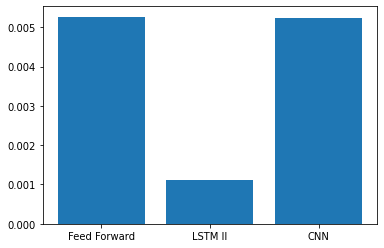

In [6]:
labels = ['Feed Forward','LSTM II', 'CNN']
values = [ff_test_loss.item(), lstm2_test_loss.item() ,cnn_test_loss.item()]

plt.bar(labels, values)